In [63]:
%pip install pandas matplotlib scipy seaborn xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz

In [2]:
from common import combine_csvs
from common import region_mapping
import common

In [27]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_LATENCY = 'Latency (ms)'

N_STARLINK = 'Starlink'
N_HOME = 'Home'

REGION_ORDER = ['N. California', 'Tokyo', 'London', 'Sydney', 'Singapore',
            'Sao Paulo', 'Bahrain', 'Mumbai', 'Cape Town']

#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
#src_dirs = [
#    ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
#    ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/'),
#    ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/'),
#    ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping/'),
#]

out_path = 'output/Ping'
filename = os.path.join(out_path, 'out_plot')

In [176]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Home', folder))
        
src_dirs = [('Starlink Koeye', 'data/Koeye/koeye_ping_measurements_2022-05-20/')]
src_dirs

[('Starlink Koeye', 'data/Koeye/koeye_ping_measurements_2022-05-20/')]

In [173]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
matplotlib.rcParams.update(plot_params)
sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_theme()
sns.set_context("paper", rc=sns_params)
sns.set(rc=sns_params)

In [174]:
df_old = pd.read_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_old[N_TIMESTAMP] = pd.to_datetime(df_old[N_TIMESTAMP])
df_old

,Latency (ms),Timestamp,Regions,Type
0,190.0,2022-06-04 03:52:17,Sao Paulo,Home
1,189.0,2022-06-04 03:52:19,Sao Paulo,Home
2,191.0,2022-06-04 03:52:20,Sao Paulo,Home
3,189.0,2022-06-04 03:52:21,Sao Paulo,Home
4,195.0,2022-06-04 03:52:22,Sao Paulo,Home
...,...,...,...,...
54583138,271.0,2022-05-14 07:31:39,Mumbai,Home
54583139,264.0,2022-05-14 07:31:40,Mumbai,Home
54583140,268.0,2022-05-14 07:31:41,Mumbai,Home
54583141,272.0,2022-05-14 07:31:42,Mumbai,Home


In [177]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in glob.glob(f'{folder}/*'):
        pattern = f"{region}/*"
        print(pattern)
        #print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), None, header=None)
        df_temp = df_temp.iloc[:,[2, 3]]
        df_temp.rename(columns={df_temp.columns[0]: N_LATENCY, df_temp.columns[1]: N_TIMESTAMP}, inplace=True)
        df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
        df_temp.sort_values(N_TIMESTAMP, inplace=True)
        df_temp[N_REGIONS] = region_mapping[os.path.basename(region)]
        df_temp[N_TYPE] = type_name

        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            #df = df.update(df_temp, errors='raise')
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
df = df.reset_index(drop=True)
df

data/Koeye/koeye_ping_measurements_2022-05-20/South_America_Sao_Paulo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Singapore/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Sydney/*
data/Koeye/koeye_ping_measurements_2022-05-20/Africa_Cape_Town/*
data/Koeye/koeye_ping_measurements_2022-05-20/US_West_N_California/*
data/Koeye/koeye_ping_measurements_2022-05-20/Middle_East_Bahrain/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Tokyo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Europe_London/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Mumbai/*


,Latency (ms),Timestamp,Regions,Type
0,240.0,2022-05-21 04:41:45,Sao Paulo,Starlink Koeye
1,234.0,2022-05-21 04:41:46,Sao Paulo,Starlink Koeye
2,244.0,2022-05-21 04:41:47,Sao Paulo,Starlink Koeye
3,294.0,2022-05-21 04:41:48,Sao Paulo,Starlink Koeye
4,226.0,2022-05-21 04:41:49,Sao Paulo,Starlink Koeye
...,...,...,...,...
1315343,313.0,2022-05-23 15:51:11,Mumbai,Starlink Koeye
1315344,311.0,2022-05-23 15:51:13,Mumbai,Starlink Koeye
1315345,293.0,2022-05-23 15:51:14,Mumbai,Starlink Koeye
1315346,306.0,2022-05-23 15:51:15,Mumbai,Starlink Koeye


In [178]:
#df = df.sort_values(N_TIMESTAMP)
#df.to_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index=False)
#df.to_csv(os.path.join(out_path, '2022-06-21_end_koeye_ping_data.csv'), index=False)

In [8]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [7]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [42]:
# Remove outliers
N_OUTLIERS = 'Outliers'
df_outliers = df.copy()
df_outliers[N_OUTLIERS] = (np.abs(stats.zscore(df_outliers[N_LATENCY], nan_policy='omit')) >= 3.5)
df_outliers = df_outliers.sort_values(N_LATENCY)
df_outliers

#df_starlink_no_outliers = df_starlink[
#    (np.abs(stats.zscore(df_starlink[N_LATENCY], nan_policy='omit')) < 3.5)
#]
#df_no_outliers = pd.concat([df_starlink_no_outliers, df_home_no_outliers]).reset_index(drop=True)
#df_no_outliers

,Latency (ms),Timestamp,Regions,Type,Outliers
41592943,25.6,2022-06-02 06:54:10,N. California,Home,False
39368161,25.8,2022-04-19 03:54:36,N. California,Home,False
7324670,25.9,2022-06-08 04:50:04,N. California,Home,False
46988678,25.9,2022-06-08 04:50:04,N. California,Home,False
39113648,25.9,2022-04-16 05:06:00,N. California,Home,False
...,...,...,...,...,...
26307436,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
27156160,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
26731814,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
19328008,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [135]:
# Filter
#df_processed = df_outliers[df_outliers[N_OUTLIERS] == False]
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-06-05':'2022-06-05 01']

df_processed = df_outliers.groupby([N_OUTLIERS, N_TYPE, N_REGIONS]).resample('H', on=N_TIMESTAMP).mean()
df_processed = df_processed.drop(N_OUTLIERS, axis=1).reset_index().dropna()
#df_processed.to_csv('output/out.csv')
df_processed

,Outliers,Type,Regions,Timestamp,Latency (ms)
0,False,Home,Bahrain,2022-05-09 09:00:00,229.356481
1,False,Home,Bahrain,2022-05-09 10:00:00,227.004169
2,False,Home,Bahrain,2022-05-09 11:00:00,226.435605
3,False,Home,Bahrain,2022-05-09 12:00:00,226.382148
4,False,Home,Bahrain,2022-05-09 13:00:00,225.956353
...,...,...,...,...,...
34954,True,Starlink,Tokyo,2022-06-16 07:00:00,4653.000000
34958,True,Starlink,Tokyo,2022-06-16 11:00:00,1219.000000
34964,True,Starlink,Tokyo,2022-06-16 17:00:00,1078.000000
34968,True,Starlink,Tokyo,2022-06-16 21:00:00,1298.000000


In [ ]:
df_regs_interp = df_processed.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [10]:
df_cdf = df_processed.groupby([N_TYPE, N_REGIONS])[N_LATENCY].apply(ecdf, False)
#df_cdf = df_processed.value_counts().sort_index().cumsum() * 1./len(df_processed)
df_cdf = df_cdf.reset_index().drop('level_2', axis=1)
df_cdf

,Type,Regions,x,y
0,Home,Bahrain,224.735891,0.001873
1,Home,Bahrain,224.801556,0.003745
2,Home,Bahrain,224.915184,0.005618
3,Home,Bahrain,224.921345,0.007491
4,Home,Bahrain,224.950236,0.009363
...,...,...,...,...
10026,Starlink,Tokyo,175.907943,0.993068
10027,Starlink,Tokyo,176.055275,0.994801
10028,Starlink,Tokyo,176.383876,0.996534
10029,Starlink,Tokyo,177.538157,0.998267


In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

/tmp/ipykernel_1937464/1260913135.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()


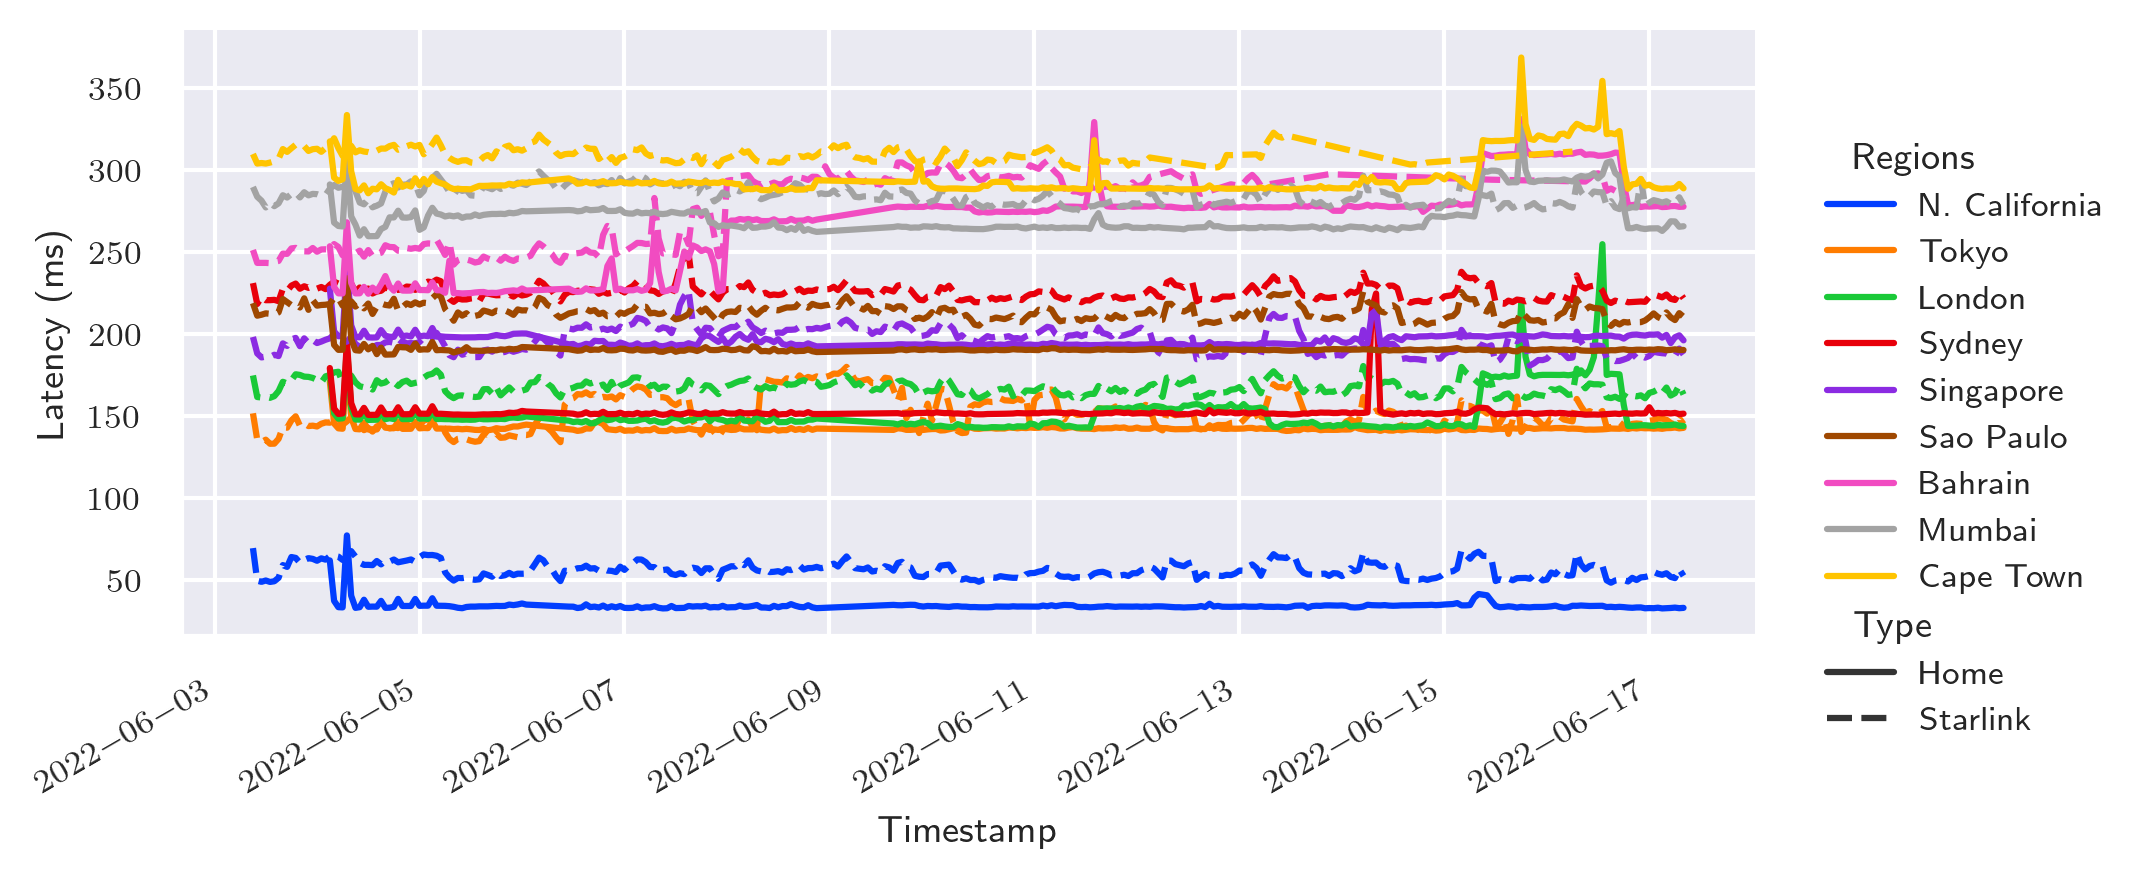

In [138]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()

g_time = sns.relplot(data=df_time[df_time[N_OUTLIERS] == False], 
                     x=N_TIMESTAMP, y=N_LATENCY, 
                     hue_order=REGION_ORDER,
                     height=3, aspect=2.03,
                     kind='line',
                     palette='bright',
                     hue=N_REGIONS, style=N_TYPE)
g_time.figure.autofmt_xdate()
ax.set_ylabel('Latency (ms)')
g_time.tight_layout()

In [45]:
df_sample = df_outliers[df_outliers[N_OUTLIERS] == False]
df_sample = df_sample.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
#df_sample = df_sample.dropna()
df_outliers_type = df_outliers[df_outliers[N_OUTLIERS] == True]
df_outliers_type = df_outliers_type.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
#df_outliers_type = df_outliers_type.dropna()

# https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe
df_sample = df_sample.groupby([N_REGIONS]).sample(5000)
df_sample = pd.concat([df_sample, df_outliers_type]).reset_index(drop=True)
df_sample

Type,Outliers,Regions,Timestamp,Home,Starlink
0,False,Bahrain,2022-05-13 11:36:29,228.0,240.0
1,False,Bahrain,2022-06-17 06:44:11,277.0,NaN
2,False,Bahrain,2022-06-10 16:34:01,275.0,286.0
3,False,Bahrain,2022-05-30 11:13:11,227.0,252.0
4,False,Bahrain,2022-06-11 15:21:19,294.0,288.0
...,...,...,...,...,...
77232,True,Tokyo,2022-06-16 07:41:27,NaN,8819.0
77233,True,Tokyo,2022-06-16 11:09:27,NaN,1219.0
77234,True,Tokyo,2022-06-16 17:57:59,NaN,1078.0
77235,True,Tokyo,2022-06-16 21:58:57,NaN,1298.0


In [48]:
df_out_sample = df_sample[df_sample[N_OUTLIERS] == True]
df_out_sample.sort_values([N_STARLINK, N_HOME]).to_csv(f'{out_path}/outliers.csv')

In [11]:
df_all = df_outliers.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

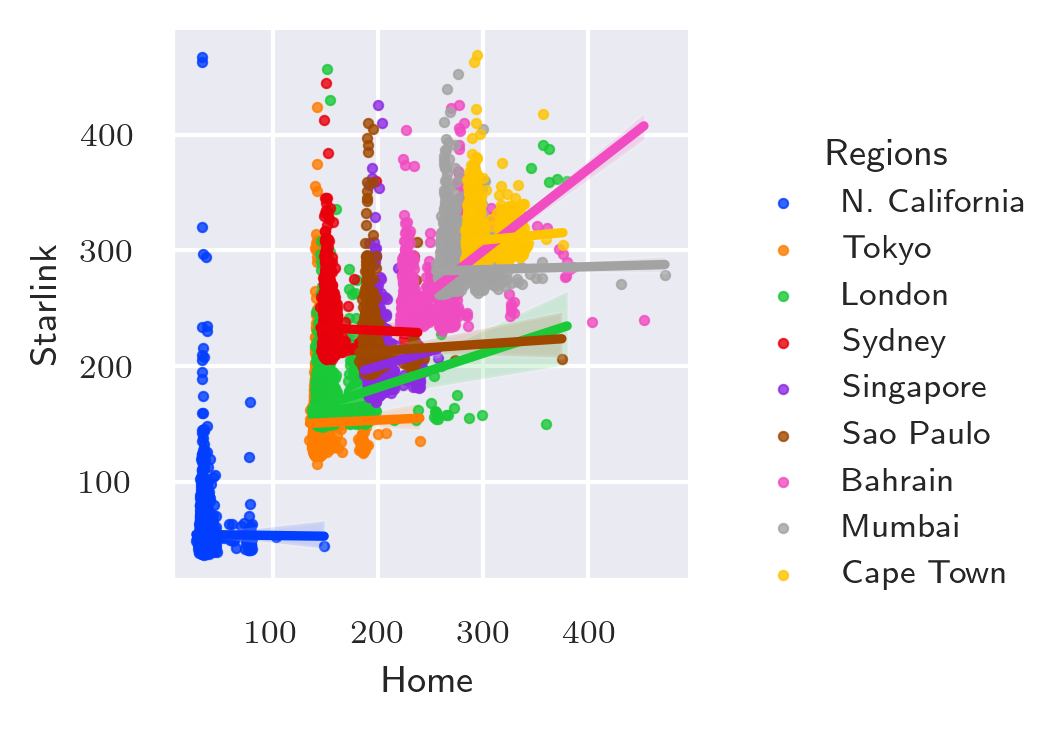

In [170]:
#df_type = df_processed.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
df_type = df_sample
df_type = df_type.dropna()
g_scatter = sns.lmplot(data=df_type[df_type[N_OUTLIERS] == False], x=N_HOME, y=N_STARLINK,
                        hue=N_REGIONS,# style=N_REGIONS, 
                        hue_order=REGION_ORDER,# style_order=REGION_ORDER,
                        palette='bright',
                        facet_kws={'sharex': False, 'sharey': False},
                        scatter_kws={'s': 5, 'linewidth': 0.5},
                       #markers='x',
                       height=2.5)
#g_scatter = sns.displot(data=df_type[df_type[N_OUTLIERS] == False], x=N_HOME, y=N_STARLINK,
#                        binwidth=10, 
#                        hue=N_REGIONS, facet_kws={'sharex': False, 'sharey': False},
#                       height=3, palette='colorblind')

axes = g_scatter.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
g_scatter.tight_layout()

In [171]:
g_scatter.savefig(f'{out_path}/regression.pdf', bbox_inches='tight')

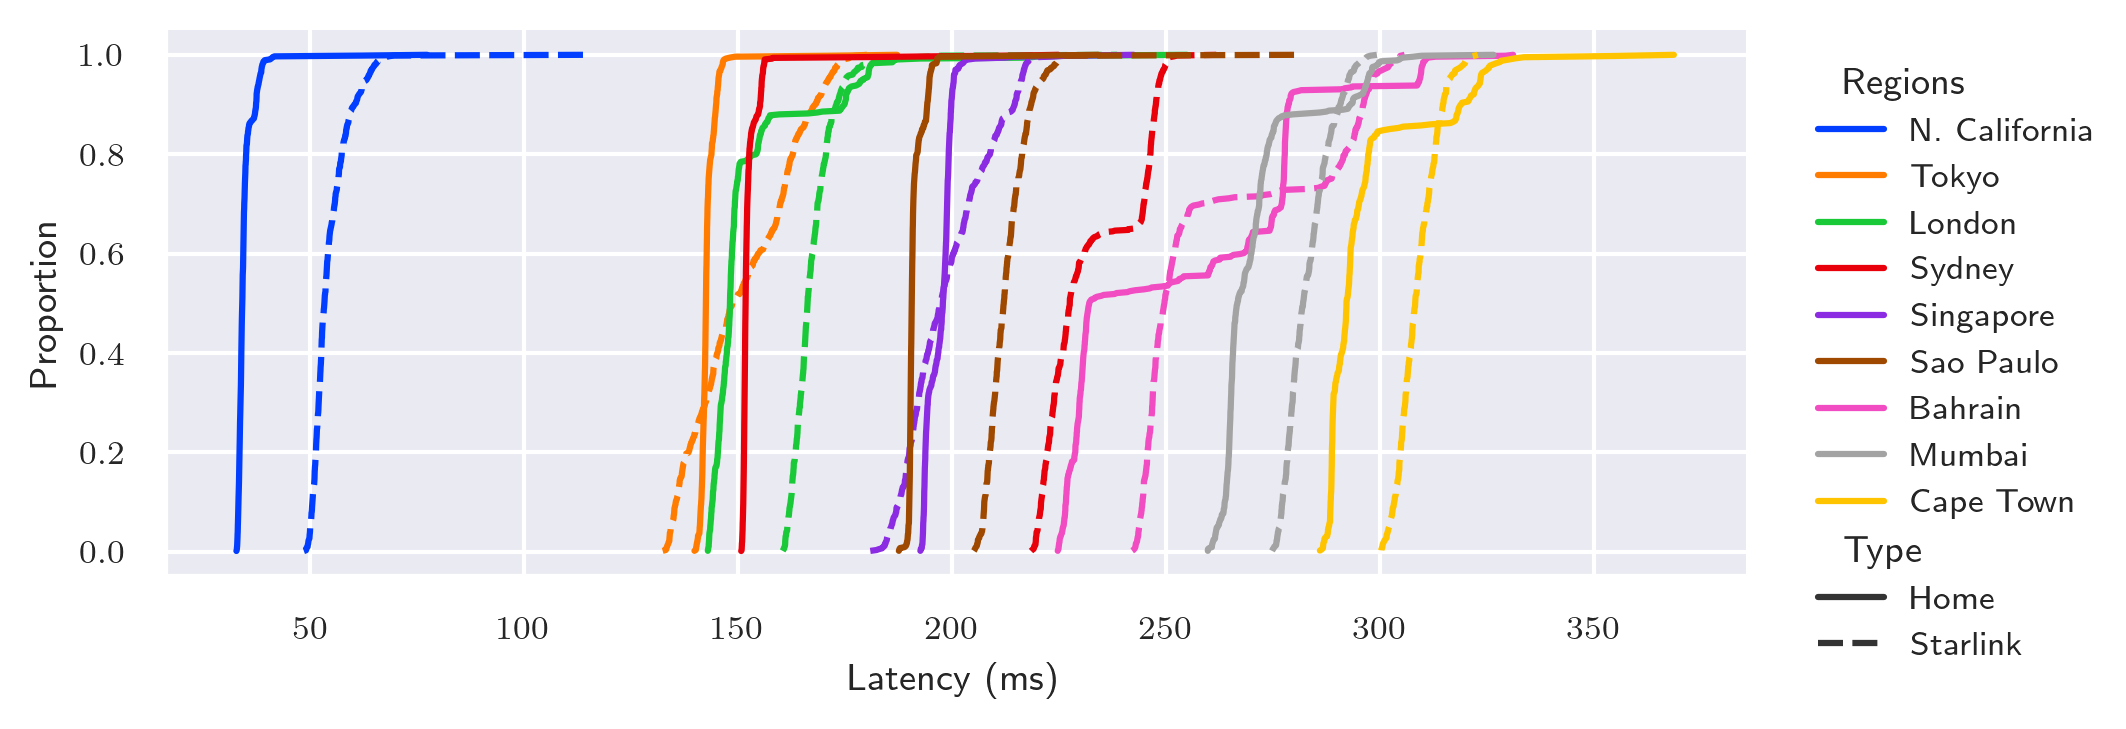

In [125]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.relplot(data=df_cdf, x='x', y='y', hue=N_REGIONS, style=N_TYPE,
                hue_order=REGION_ORDER, kind='line', palette='bright',
                height=2.5, aspect=2.424)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set(xlabel='Latency (ms)', ylabel='Proportion')
g_cdf.tight_layout()

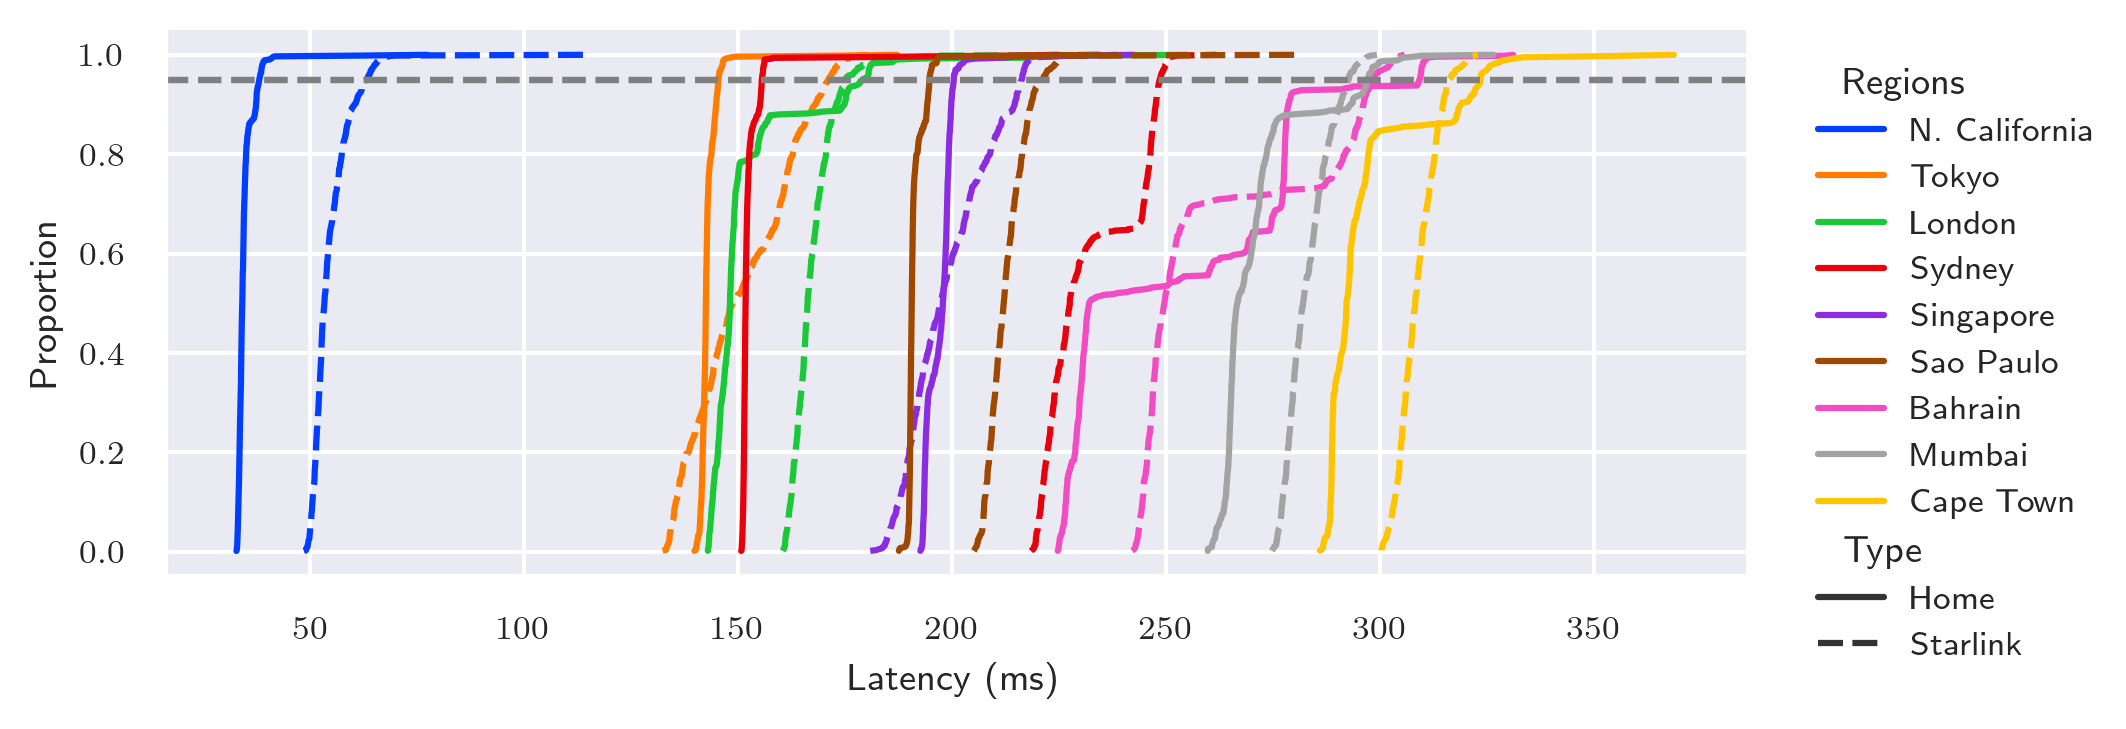

In [127]:
g_cdf.refline(y=0.95)
g_cdf.tight_layout()

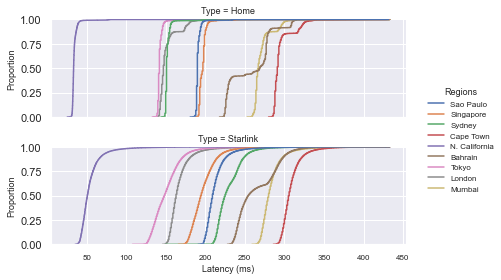

In [71]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)

g_hist = sns.displot(
    data=df_no_outliers, 
    x=N_LATENCY, row=N_TYPE, hue=N_REGIONS, kind='ecdf', height=2, aspect=2.98)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()


In [ ]:
#g_hist.refline(y=0.9)
g_hist.refline(y=0.95)
#g_hist.refline(y=0.99)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()

In [19]:
g_hist.savefig(f'{filename}_cdf.pgf', bbox_inches='tight')

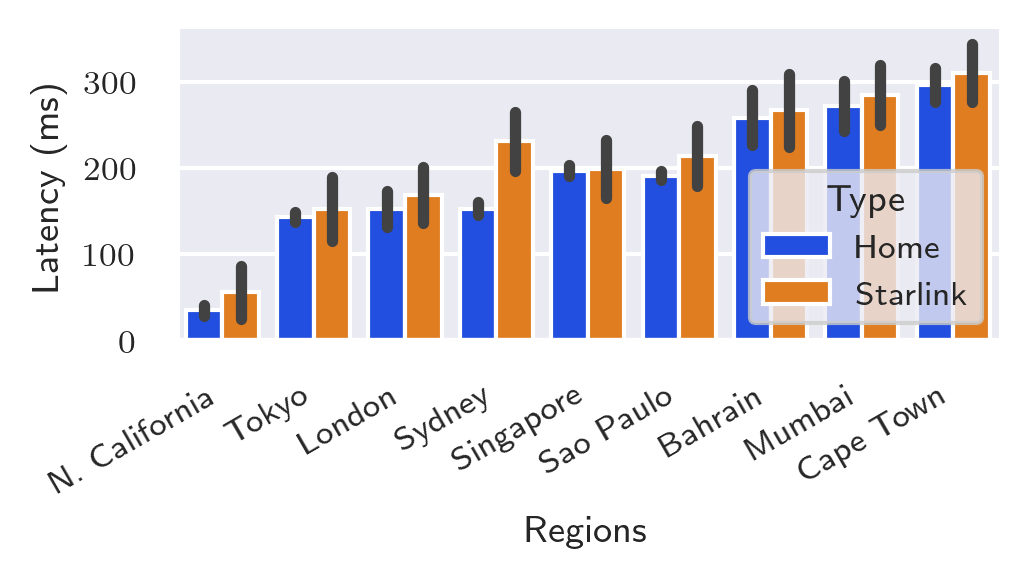

In [129]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
g_avg = sns.catplot(data=df,
                    sharey=False,
                    x=N_REGIONS, y=N_LATENCY, hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK],
                    order=REGION_ORDER,
                    legend_out=False,
                    kind='bar', ci='sd',
                    palette='bright',
                    height=2, aspect=1.75)

g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="{row_name}")
g_avg.tight_layout()

#df_averaged

In [134]:
g_avg.savefig(f'{filename}_avg.pdf', bbox_inches='tight')

In [64]:
nt_perc = df_outliers.groupby([N_TYPE, N_REGIONS]).quantile(.90)
nf_perc = df_outliers.groupby([N_TYPE, N_REGIONS]).quantile(.95)
nn_perc = df_outliers.groupby([N_TYPE, N_REGIONS]).quantile(.99)

In [66]:
def diff_table(percentile):
    df_perc = percentile.reset_index().pivot(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)
    df_perc['diff'] = df_perc['Starlink'] - df_perc['Home']
    return df_perc.reset_index().pivot_table(columns=N_REGIONS, values='diff')
    
df_perc = diff_table(nt_perc)
df_perc = pd.concat([df_perc, diff_table(nf_perc)])
df_perc = pd.concat([df_perc, diff_table(nn_perc)])
df_perc['Percentile'] = ['90%', '95%', '99%']
df_perc = df_perc.set_index('Percentile')
df_perc

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Percentile,,,,,,,,,
90%,17.0,5.0,8.0,6.0,31.1,34.0,16.0,95.0,27.0
95%,0.0,10.0,15.0,13.0,39.9,43.0,24.0,103.0,35.0
99%,35.0,46.0,52.0,48.0,77.3,81.0,52.0,102.0,63.0


In [83]:
df_type_avg = df_outliers[df_outliers[N_OUTLIERS] == False].groupby([N_TYPE]).mean()
df_type_avg

,Latency (ms),Outliers
Type,,
Home,183.604080,0.0
Starlink,200.301787,0.0


In [110]:
df_star = df_outliers[df_outliers[N_TYPE] == N_STARLINK]
df_corr = df_star.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
df_corr

In [112]:
df_corr = df_corr.corr()
df_corr

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Regions,,,,,,,,,
Bahrain,1.000000,0.531023,0.435916,0.523741,0.368044,0.512611,0.474942,0.352300,0.510409
Cape Town,0.531023,1.000000,0.530960,0.615328,0.538009,0.629372,0.617139,0.696385,0.526976
London,0.435916,0.530960,1.000000,0.533721,0.513696,0.515329,0.561255,0.494996,0.577317
Mumbai,0.523741,0.615328,0.533721,1.000000,0.493145,0.567466,0.569023,0.640166,0.498123
N. California,0.368044,0.538009,0.513696,0.493145,1.000000,0.483147,0.457279,0.390160,0.540791
Sao Paulo,0.512611,0.629372,0.515329,0.567466,0.483147,1.000000,0.492273,0.500691,0.555297
Singapore,0.474942,0.617139,0.561255,0.569023,0.457279,0.492273,1.000000,0.600782,0.609283
Sydney,0.352300,0.696385,0.494996,0.640166,0.390160,0.500691,0.600782,1.000000,0.538216
Tokyo,0.510409,0.526976,0.577317,0.498123,0.540791,0.555297,0.609283,0.538216,1.000000


In [82]:
file_path = os.path.join('output/Ping/', 'Percentiles.tex')
styler = df_perc.style
styler.format(precision=1)
styler.to_latex(file_path)

In [139]:
g_time.savefig(f'{filename}.pdf', bbox_inches='tight')
g_cdf.savefig(f'{filename}_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')